Modeling: Mass Total + Source Parametric
========================================

To fit a lens model to an interferometer dataset, we again perform lens modeling using a `NonLinearSearch`.
However, unlike CCD `Imaging` data, we fit the lens model in Fourier space, or the `uv-plane`, which circumvents issues
that arise when trying to fit CLEANED images of interferometer data.

A big challenge when fitting interferometer datasets is the huge quantity of data. Very long baseline ALMA or JVLA
observations observe in excess of *millions* of visibilities, which can make certain approaches to modeling
interferometer data extremely slow and expensive.

In this example, we fit an interferometer dataset consisting of 1 million visibilities, assuming a parametric
`EllipticalSersic` model for the source. This analysis would be very expensive if a direct Fourier transform is used to
transform the lens model-image from  real-space to Fourier space and compare with the visibilities in the uv-plane.

Instead, **PyAutoLens** uses the non-uniform fast Fourier transform (NUFFT) of the package PyNUFFT
(https://github.com/jyhmiinlin/pynufft)  which ensures we can fit > 1 million visibilities in an efficient manner!

In this example script, we fit interferometer data of a strong lens system where:

 - The lens galaxy's light is omitted (and is not present in the simulated data).
 - The lens galaxy's total mass distribution is modeled as an `EllipticalIsothermal`.
 - The source galaxy's light is modeled parametrically as an `EllipticalSersic`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Load the strong lens dataset `mass_sie__source_sersic` `from .fits files.

Unlike the other example scripts, we use the `Interferometer` class to load this dataset, passing it paths to the .fits
files containing its visibilities, noise-map and uv_wavelengths.

/mnt/c/Users/Jammy/Code/PyAuto/PyAutoArray/autoarray/plot/mat_wrap/mat_plot.py:176: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows, columns, self.subplot_index)


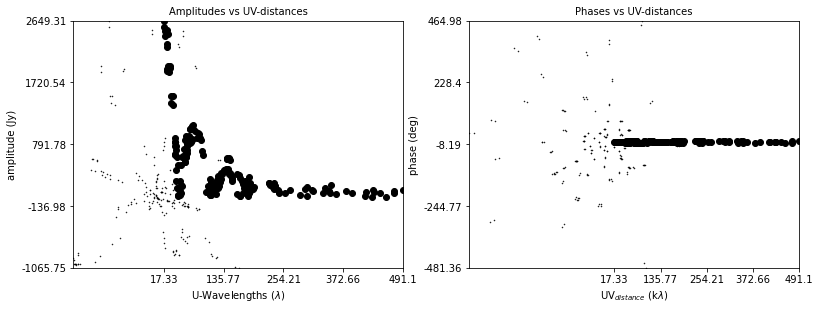

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()

The perform a fit, we need two masks, firstly a ‘real-space mask’ which defines the grid the image of the lensed 
source galaxy is evaluated using.

In [3]:
real_space_mask = al.Mask2D.circular(
    shape_native=(200, 200), pixel_scales=0.05, radius=3.0
)

We also need a ‘visibilities mask’ which defining which visibilities are omitted from the chi-squared evaluation.

In [4]:
visibilities_mask = np.full(fill_value=False, shape=interferometer.visibilities.shape)

__Phase__

To perform lens modeling, we create a *PhaseInterferometer* object, which comprises:

   - The `GalaxyModel`'s used to fit the data.
   - The `SettingsPhase` which customize how the model is fitted to the data.
   - The `NonLinearSearch` used to sample parameter space.
   
Once we have create the phase, we `run` it by passing it the data and mask.

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens mooel is:

 - An `EllipticalIsothermal` `MassProfile`.for the lens galaxy's mass (5 parameters).
 - An `EllipticalSersic` `LightProfile`.for the source galaxy's light (7 parameters).

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12.

In [5]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

Next, we specify the *SettingsPhaseInterferometer*, which describes how the model is fitted to the data in the log 
likelihood function. Below, we specify:
 
 - That a regular `Grid2D` is used to fit create the model-image (in real space) when fitting the data 
   (see `autolens_workspace/examples/grids.py` for a description of grids).
   
 - The sub-grid size of this real-space grid.
 
 - The method used to Fourier transform this real-space image of the strong lens to the uv-plane, to compare directly
   to the visiblities. In this example, we use a non-uniform fast Fourier transform, which operates efficiently
   on interferometer datasets containing ~1-10 million visibilities.

In [6]:
settings_masked_interferometer = al.SettingsMaskedInterferometer(
    grid_class=al.Grid2D, sub_size=2, transformer_class=al.TransformerNUFFT
)

settings = al.SettingsPhaseInterferometer(
    settings_masked_interferometer=settings_masked_interferometer
)

__Search__

The lens model is fitted to the data using a `NonLinearSearch`, which we specify below. In this example, we use the
nested sampling algorithm Dynesty (https://dynesty.readthedocs.io/en/latest/), with:

 - 50 live points.

The script `autolens_workspace/notebooks/interferometer/modeling/customize/non_linear_searches.py` gives a description 
of the types of non-linear searches that can be used with **PyAutoLens**. If you do not know what a `NonLinearSearch` 
is or how it operates, I recommend you complete chapters 1 and 2 of the HowToLens lecture series.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/interferometer/mass_sie__source_sersic/phase_mass[sie]_source[bulge]`.

In [7]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer", dataset_name),
    name="phase_mass[sie]_source[bulge]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [8]:
phase = al.PhaseInterferometer(
    search=search,
    real_space_mask=real_space_mask,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

We can now begin the fit by passing the dataset and visibilties mask to the phase, which will use the `NonLinearSearch` 
to fit the model to the data. 

The fit outputs visualization on-the-fly, so checkout the path 
`autolens_workspace/output/examples/phase_mass[sie]_source[bulge]` to see how your fit is doing!

In [9]:
result = phase.run(dataset=interferometer, mask=visibilities_mask)

INFO:root:phase_mass[sie]_source[bulge] already completed, skipping non-linear search.


The phase above returned a result, which, for example, includes the lens model corresponding to the maximum
log likelihood solution in parameter space.

In [10]:
print(result.max_log_likelihood_instance)

It also contains instances of the maximum log likelihood Tracer and FitImaging, which can be used to visualize
the fit.

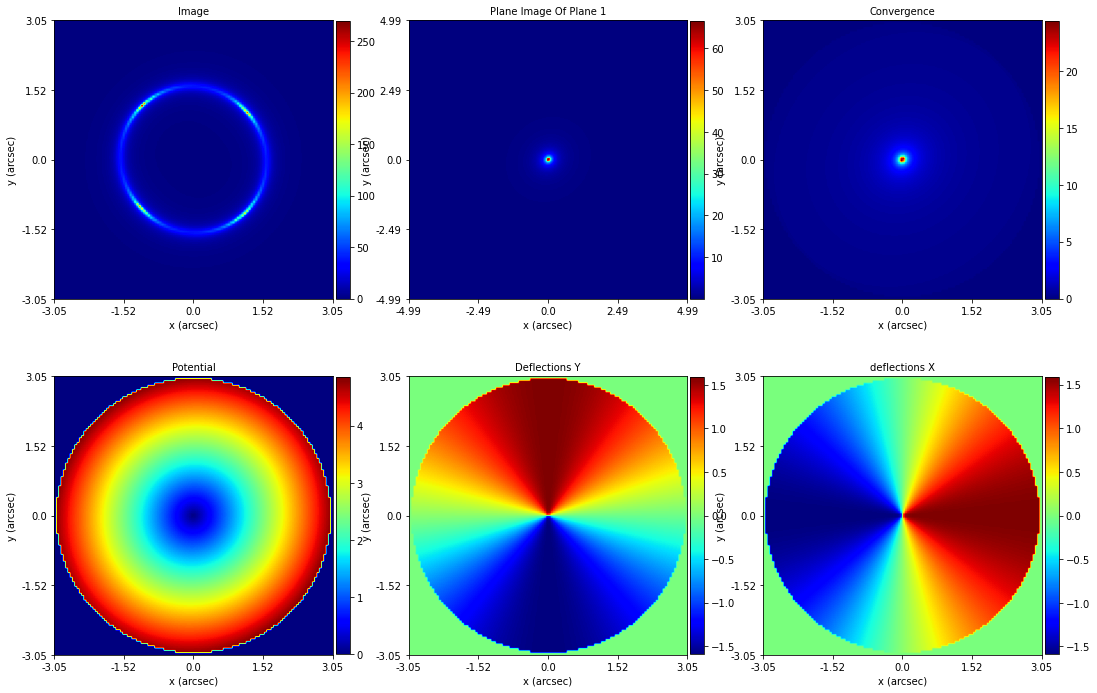

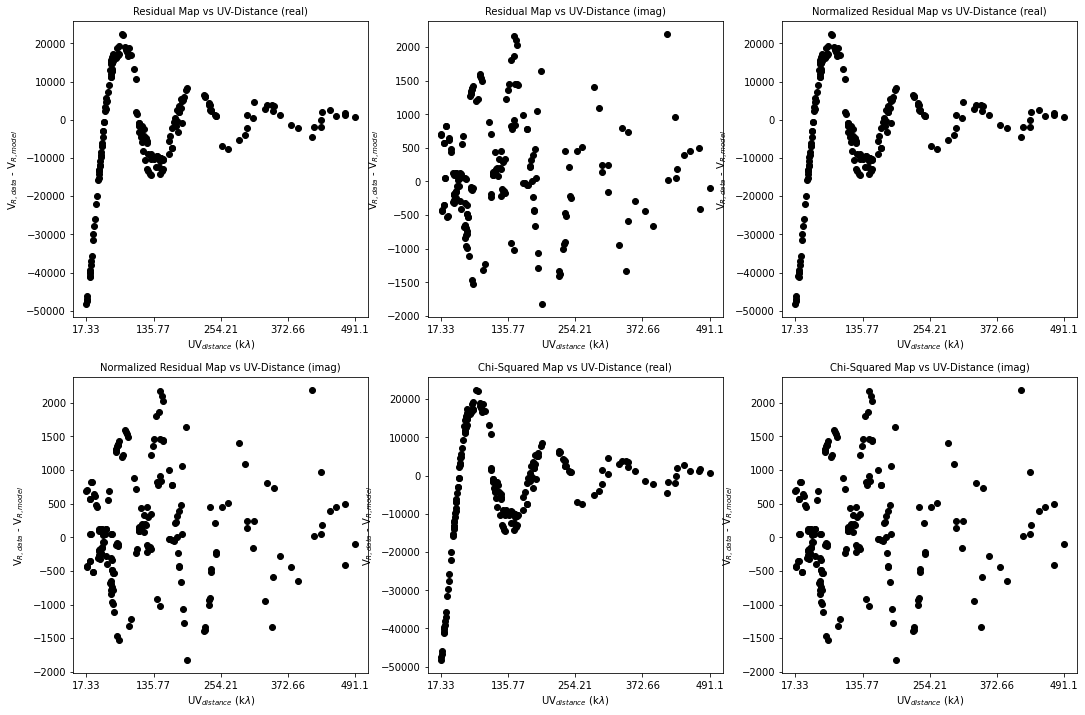

In [11]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=real_space_mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()
fit_interferometer_plotter = aplt.FitInterferometerPlotter(
    fit=result.max_log_likelihood_fit
)
fit_interferometer_plotter.subplot_fit_interferometer()

Checkout `autolens_workspace/notebooks/interferometer/modeling/results.py` for a full description of the result object.